# Visualizaciones con geopandas

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


In [2]:
df = pd.read_parquet('data\df_filtered.parquet')

In [3]:
df.columns

Index(['WS10M', 'SQ1', 'T2M * TS', 'elevation * T2MDEW', 'SQ4', 'CULT_LAND',
       'fips', 'elevation * WS50M', 'QV2M * WS10M', 'lon', 'month',
       'T2M_RANGE', 'TS * WS10M', 'FOR_LAND', 'year', 'GRS_LAND',
       'elevation * PRECTOT', 'PRECTOT * TS', 'slope2', 'aspectN', 'SQ7',
       'SQ5', 'lat', 'NVG_LAND', 'PRECTOT + T2M', 'PS + WS50M', 'aspectS',
       'WS50M_RANGE', 'day', 'slope7', 'PS * TS', 'aspectE', 'WS10M_RANGE',
       'elevation * TS', 'URB_LAND', 'score_final_interpolated'],
      dtype='object')

In [4]:
df.shape

(1644000, 36)

In [5]:
df.score_final_interpolated.value_counts()

score_final_interpolated
0.0    1075750
1.0     269027
2.0     147296
3.0      84748
4.0      47971
5.0      19208
Name: count, dtype: int64

In [6]:
# Reemplazar las clases 4 y 5 por la clase 3 en la columna 'score_final_interpolated'
df['score_final_interpolated'] = df['score_final_interpolated'].replace({4: 3, 5: 3})

In [7]:
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

In [8]:
X = df.drop(columns=['score_final_interpolated'])
y = df['score_final_interpolated']

In [9]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [10]:
# Fecha de corte.
cutoff_date = pd.Timestamp('2019-01-01')
# Separar los datos de entrenamiento (antes de 2019) y prueba (desde 2019)
train_mask = df['date'] < cutoff_date
test_mask = df['date'] >= cutoff_date
# Crear conjuntos de entrenamiento y prueba
X_train = df.loc[train_mask].drop(columns=['score_final_interpolated', 'date'])
y_train = df.loc[train_mask]['score_final_interpolated']
X_test = df.loc[test_mask].drop(columns=['score_final_interpolated', 'date'])
y_test = df.loc[test_mask]['score_final_interpolated']


In [11]:
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (1278500, 35), (1278500,)
Conjunto de prueba: (365500, 35), (365500,)


In [12]:
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (1278500, 35), (1278500,)
Conjunto de prueba: (365500, 35), (365500,)


In [14]:
lgbm_best = joblib.load('models/lightgbm_model_6.pkl')


In [15]:
# Reconstruir la columna 'date' a partir de 'year', 'month' y 'day'
X_test['date'] = pd.to_datetime(X_test[['year', 'month', 'day']])

# Asegurarnos de que 'fips' es el identificador del sitio
# Combinar X_test con y_test para poder filtrar fácilmente
X_test['score_final_interpolated'] = y_test

# Ordenar por 'fips' y 'date' para garantizar que los registros estén en orden temporal
X_test_sorted = X_test.sort_values(by=['fips', 'date'])

# Filtrar solo los próximos 30 días por cada sitio 'fips'
X_test_30_days = X_test_sorted.groupby('fips').head(30)

# Separar las características y el target de nuevo
y_test_30_days = X_test_30_days['score_final_interpolated']
X_test_30_days = X_test_30_days.drop(columns=['score_final_interpolated', 'date'])  # Eliminamos también la columna 'date'

# Predecir solo para los próximos 30 días por cada sitio
y_pred_30_days = lgbm_best.predict(X_test_30_days)
y_prob_30_days = lgbm_best.predict_proba(X_test_30_days)

# Imprimir los resultados
print("Predicciones para los próximos 30 días por cada sitio:")
print(y_pred_30_days)

[LightGBM] [Warning] feature_fraction is set=0.8445059004982389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8445059004982389
[LightGBM] [Warning] bagging_fraction is set=0.9089493179526446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089493179526446
[LightGBM] [Warning] feature_fraction is set=0.8445059004982389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8445059004982389
[LightGBM] [Warning] bagging_fraction is set=0.9089493179526446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089493179526446
Predicciones para los próximos 30 días por cada sitio:
[2. 2. 2. ... 0. 0. 0.]


In [16]:
# También puedes evaluar el modelo en esos 30 días por sitio
print("Reporte de clasificación para los próximos 30 días por sitio:")
print(classification_report(y_test_30_days, y_pred_30_days))

Reporte de clasificación para los próximos 30 días por sitio:
              precision    recall  f1-score   support

         0.0       0.93      0.43      0.59     13528
         1.0       0.04      0.32      0.07       534
         2.0       0.02      0.17      0.04       420
         3.0       0.11      0.34      0.17       518

    accuracy                           0.42     15000
   macro avg       0.28      0.31      0.22     15000
weighted avg       0.84      0.42      0.54     15000



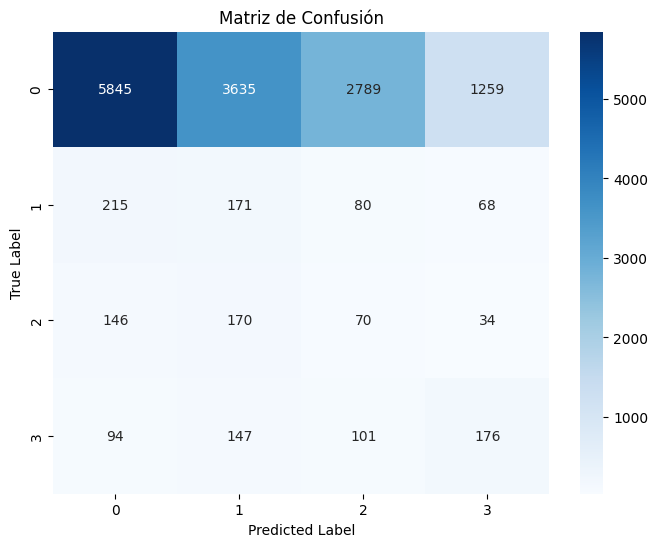

In [17]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_30_days, y_pred_30_days)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


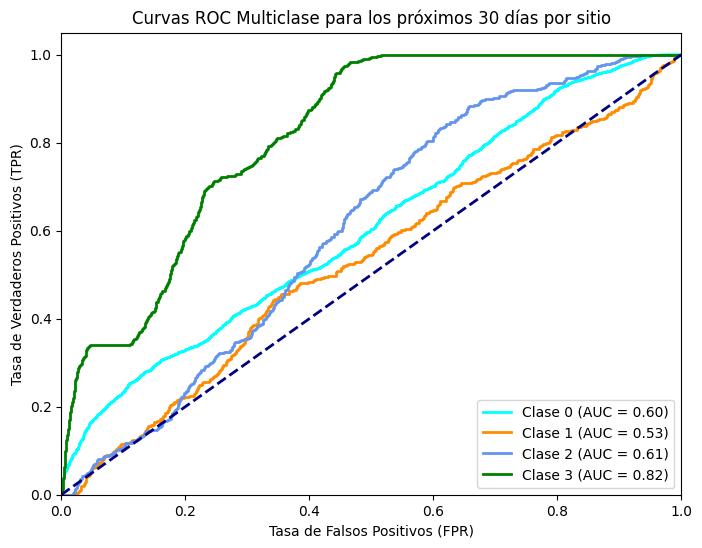

In [18]:
# Binarizar las etiquetas de prueba para calcular la curva ROC multiclase
n_classes = len(np.unique(y_test_30_days))  # Número de clases
y_test_bin = label_binarize(y_test_30_days, classes=np.arange(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular curvas ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_30_days[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC para cada clase
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'red']  # Asignar colores a cada clase

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Gráfica ROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase para los próximos 30 días por sitio')
plt.legend(loc="lower right")
plt.show()

In [19]:
# df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
# df = df[['fips', 'lat', 'lon', 'date', 'score_final_interpolated']]
# transformo a gdf con geopandas
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

In [25]:
import plotly.express as px

gdf = gdf[(gdf['date'].dt.day == 15) | (gdf['date'].dt.day == 1)]

# Crear el mapa de dispersión
fig = px.scatter_mapbox(data_frame=gdf,
                        lat='lat',
                        lon='lon',
                        color='score_final_interpolated',
                        size_max=15,  # Ajusta este valor para cambiar el tamaño máximo de los puntos
                        zoom=3,
                        center={"lat": 37.0902, "lon": -98.7129},
                        mapbox_style='open-street-map',
                        color_continuous_scale='viridis',
                        range_color=(0, 3),
                        animation_frame='date',
                        width=1300,
                        height=600,
                        hover_name='fips'
                        )
# Ajustar la velocidad de la animación
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 50

fig.show()
fig.write_html('fips_seleccionados_v2.html')

In [26]:
# Vamos a explorar y_test y las predicciones
# ploteamos el mapa para y_test


X_test_30_days['date'] = pd.to_datetime(X_test_30_days[['year', 'month', 'day']])

gdf = gpd.GeoDataFrame(pd.concat([X_test_30_days, y_test_30_days], axis=1), geometry=gpd.points_from_xy(X_test_30_days.lon, X_test_30_days.lat)) 

# gdf = gdf[(gdf['date'].dt.day == 15) | (gdf['date'].dt.day == 1)]
gdf = gdf[['fips', 'lat', 'lon', 'date', 'score_final_interpolated']]
# ordeno por date ascendente
gdf = gdf.sort_values(by='date')

# Crear el mapa de dispersión
fig = px.scatter_mapbox(data_frame=gdf,
                        lat='lat',
                        lon='lon',
                        color='score_final_interpolated',
                        size_max=15,  # Ajusta este valor para cambiar el tamaño máximo de los puntos
                        zoom=3,
                        center={"lat": 37.0902, "lon": -98.7129},
                        mapbox_style='open-street-map',
                        color_continuous_scale='viridis',
                        range_color=(0, 3),
                        animation_frame='date',
                        width=1300,
                        height=600,
                        hover_name='fips'
                        )
# Ajustar la velocidad de la animación
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 50

fig.show()
fig.write_html('fips_seleccionados_test_v2.html')

In [27]:
# ploteamos el mapa para y_pred_30_days
# Vamos a explorar y_test y las predicciones
# ploteamos el mapa para y_test


X_test_30_days['date'] = pd.to_datetime(X_test_30_days[['year', 'month', 'day']])

gdf = gpd.GeoDataFrame(pd.concat([X_test_30_days, pd.Series(y_pred_30_days, index=X_test_30_days.index, name='score_pred')], axis=1), geometry=gpd.points_from_xy(X_test_30_days.lon, X_test_30_days.lat)) 

# gdf = gdf[(gdf['date'].dt.day == 15) | (gdf['date'].dt.day == 1)]
gdf = gdf[['fips', 'lat', 'lon', 'date', 'score_pred']]
# ordeno por date ascendente
gdf = gdf.sort_values(by='date')

# Crear el mapa de dispersión
fig = px.scatter_mapbox(data_frame=gdf,
                        lat='lat',
                        lon='lon',
                        color='score_pred',
                        size_max=15,  # Ajusta este valor para cambiar el tamaño máximo de los puntos
                        zoom=3,
                        center={"lat": 37.0902, "lon": -98.7129},
                        mapbox_style='open-street-map',
                        color_continuous_scale='viridis',
                        range_color=(0, 3),
                        animation_frame='date',
                        width=1300,
                        height=600,
                        hover_name='fips'
                        )
# Ajustar la velocidad de la animación
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 50

fig.show()
fig.write_html('fips_seleccionados_pred_v2.html')

In [28]:
# Vamos a explorar y_test y las predicciones
# ploteamos el mapa para y_test


X_test_30_days['date'] = pd.to_datetime(X_test_30_days[['year', 'month', 'day']])

gdf = gpd.GeoDataFrame(pd.concat([X_test_30_days, y_test_30_days], axis=1), geometry=gpd.points_from_xy(X_test_30_days.lon, X_test_30_days.lat)) 

# gdf = gdf[(gdf['date'].dt.day == 15) | (gdf['date'].dt.day == 1)]
gdf = gdf[['fips', 'lat', 'lon', 'date', 'score_final_interpolated']]

# Crear el mapa de dispersión
fig = px.scatter_mapbox(data_frame=gdf,
                        lat='lat',
                        lon='lon',
                        color='score_final_interpolated',
                        size_max=15,  # Ajusta este valor para cambiar el tamaño máximo de los puntos
                        zoom=3,
                        center={"lat": 37.0902, "lon": -98.7129},
                        mapbox_style='open-street-map',
                        color_continuous_scale='viridis',
                        range_color=(0, 3),
                        animation_frame='date',
                        width=1300,
                        height=600,
                        hover_name='fips'
                        )
# Ajustar la velocidad de la animación
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 50

fig.show()
fig.write_html('fips_seleccionados_test_v2.html')